# 1) Import Libraries

In [ ]:
!pip install copick git+https://github.com/copick/copick-utils.git scikit-image cupy-cuda12x torch torchvision tqdm matplotlib
!pip install monai

import numpy as np
from glob import glob
import os
import pandas as pd
import zarr
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from mpl_toolkits.mplot3d import Axes3D
from monai.losses import DiceLoss
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from torch.utils.data import DataLoader, random_split, TensorDataset
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

  Cloning https://github.com/copick/copick-utils.git to /tmp/pip-req-build-6e8xow3o
  Running command git clone --filter=blob:none --quiet https://github.com/copick/copick-utils.git /tmp/pip-req-build-6e8xow3o
  Resolved https://github.com/copick/copick-utils.git to commit 79315f3fca71ebfaaff54198b3e08a3bd2ebc63f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# 2) Load Zarr Data and Centroids (from JSON)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Location of the files in the cluster: /home_expes/collections/kaggle-competition-CryoET/uster

Mounted at /content/drive


In [ ]:
def read_zarr(run: str) -> zarr.hierarchy.Group:

    """Reads a zarr data (we only use the denoised.zarr files)"""

    return zarr.open(f"/content/drive/MyDrive/DL2_Data/czii-cryo-et-object-identification/train/static/ExperimentRuns/{run}/VoxelSpacing10.000/denoised.zarr", mode="r")

def read_run(run: str) -> pd.DataFrame:

    """Creates a dataframe with the coordinates of the
    centroids of the particles.
    It uses the information in the overlay.
    It needs to know the name of
    an experiment (also called run)
    We get the name of the experiment by selecting an element of the list run"""

    paths = glob(f"/content/drive/MyDrive/DL2_Data/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/{run}/Picks/*.json")
    df = pd.concat([pd.read_json(x) for x in paths]).reset_index(drop=True)
    for axis in "x", "y", "z":
        df[axis] = df.points.apply(lambda x: x["location"][axis])
    return df

# 3) Data Preprocessing

## Convert Centroids to Voxels

In [ ]:
def map_overlay_to_voxels(df, voxel_spacing=10, volume_shape=(100, 100, 100)):

    """It creates a 3D image (volumen) using the information of the dataframe about
    the centroids of the particles.
    Right now, it only works for thyroglobulin.
    You can change thyroglobulin for another particle.
    Or you can create a function that multilabels the voxels.
    """

    voxel_labels = np.zeros(volume_shape, dtype=int)
    for _, row in df.iterrows():
        x, y, z = [int(row[axis] / voxel_spacing) for axis in ['x', 'y', 'z']]
        voxel_labels[z, y, x] = 1 if row['pickable_object_name'] == 'thyroglobulin' else 0
    return voxel_labels

## Expand Centroids into Blobs

In [ ]:
def expand_labels_with_blobs(voxel_labels, radius):

    """Expands labeled centroids (value = 1) in a 3D numpy array into spherical blobs."""

    radius = int(radius)
    z, y, x = np.ogrid[-radius:radius+1, -radius:radius+1, -radius:radius+1]
    distance = np.sqrt(x**2 + y**2 + z**2)
    sphere = distance <= radius

    expanded_labels = np.zeros_like(voxel_labels, dtype=np.uint8)
    centroids = np.argwhere(voxel_labels == 1)

    for centroid in centroids:
        cz, cy, cx = centroid
        z_min, z_max = max(0, cz - radius), min(voxel_labels.shape[0], cz + radius + 1)
        y_min, y_max = max(0, cy - radius), min(voxel_labels.shape[1], cy + radius + 1)
        x_min, x_max = max(0, cx - radius), min(voxel_labels.shape[2], cx + radius + 1)
        roi = expanded_labels[z_min:z_max, y_min:y_max, x_min:x_max]
        roi[sphere] = 1
    return expanded_labels

## Create Subvolumes

Although the 3d image (called volume) of an experiment is useful for visualization,
it might be too big for your memory when you try to train a model.
A way to deal with this problem, is to cut the 3d images into 3d patches (called subvolumes)

In [ ]:
def preprocess_and_filter_subvolumes(zarr_data, labels, target_shape=(32, 32, 32), background_fraction=0.2, normalize=True):

    """
    Generate sub-volumes and corresponding voxel-wise labels,
    keeping those sub volumes with at least one `1` label and a random fraction of `0`-only sub volumes. This means that
    the functin will filter out the sub-volumes that do not have relevant data.
    A subvolume does not have relevant data if the associated labels do not indicate the
    presence of a particle there.
    You can choose to keep some irrelevant data, for that ue the background_fraction argument.

    Arguments:
        zarr_data: 3D numpy array of voxel data.
        labels: 3D numpy array of voxel labels.
        target_shape: Tuple defining the shape of each sub-volume.
        background_fraction: Fraction of `0`-only sub-volumes to include.

    Returns:
        filtered_volumes: Filtered sub-volumes.
        filtered_labels: Corresponding labels for the filtered sub-volumes.
    """

    sub_volumes = []
    sub_labels = []
    background_volumes = []
    background_labels = []

    for x in range(0, zarr_data.shape[0] - target_shape[0] + 1, target_shape[0]):
        for y in range(0, zarr_data.shape[1] - target_shape[1] + 1, target_shape[1]):
            for z in range(0, zarr_data.shape[2] - target_shape[2] + 1, target_shape[2]):
                crop = zarr_data[x:x + target_shape[0], y:y + target_shape[1], z:z + target_shape[2]]
                crop_label = labels[x:x + target_shape[0], y:y + target_shape[1], z:z + target_shape[2]]
                if np.any(crop_label == 1):
                    sub_volumes.append(crop)
                    sub_labels.append(crop_label)
                else:
                    background_volumes.append(crop)
                    background_labels.append(crop_label)

    if background_fraction > 0 and len(background_volumes) > 0:
        sample_size = int(len(sub_volumes) * background_fraction)
        sampled_indices = np.random.choice(len(background_volumes), size=sample_size, replace=False)
        sub_volumes.extend([background_volumes[i] for i in sampled_indices])
        sub_labels.extend([background_labels[i] for i in sampled_indices])
    if normalize:
        return ((np.array(sub_volumes) - np.min(np.array(sub_volumes))) / (np.max(np.array(sub_volumes)) - np.min(np.array(sub_volumes)))), np.array(sub_labels)
    return np.array(sub_volumes), np.array(sub_labels)

In [ ]:
# Creates a list with the names of the experiments
runs = sorted(glob('/content/drive/MyDrive/DL2_Data/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/*'))
runs = [os.path.basename(x) for x in runs]
print(f"Runs available: {runs}")

# Ensure the device is set to CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize lists to store the results for all runs
all_filtered_volumes = []
all_filtered_labels = []

# Loop through each experiment to process its data with a progress bar
for run in tqdm(runs, desc="Processing experiments"):
    # Open the Zarr file for the current experiment
    zarr_data_nparray = read_zarr(run)

    # Read the JSON file containing centroid information
    df = read_run(run)

    # Map centroids to voxel labels (this will create a 3D target image with labels)
    voxel_labels = map_overlay_to_voxels(df, voxel_spacing=10, volume_shape=zarr_data_nparray["0"].shape)

    # Convert voxel labels to a PyTorch tensor and move it to the GPU (if available)
    voxel_labels_tensor = torch.tensor(voxel_labels, dtype=torch.float32).to(device)

    # Expand labels to fill a sphere (use blobs to expand label)
    radius_thyroglobulin = 6  # Radius in voxels
    voxel_labels_blob = expand_labels_with_blobs(voxel_labels, radius=radius_thyroglobulin)

    # Create subvolumes and their associated targets (filtered subvolumes and labels)
    filtered_volumes, filtered_labels = preprocess_and_filter_subvolumes(
        zarr_data_nparray["0"], voxel_labels_blob, target_shape=(32, 32, 32), background_fraction=0, normalize=True
    )

    # Debugging
    unique, counts = np.unique(filtered_labels, return_counts=True)
    print(f"Filtered label distribution: {dict(zip(unique, counts))}")


    # Convert filtered volumes and labels to tensors and move them to GPU
    filtered_volumes_tensor = torch.tensor(filtered_volumes, dtype=torch.float32).to(device)
    filtered_labels_tensor = torch.tensor(filtered_labels, dtype=torch.float32).to(device)

    # Store the results for this run (moving back to CPU if needed for further processing)
    all_filtered_volumes.append(filtered_volumes_tensor.cpu().numpy())
    all_filtered_labels.append(filtered_labels_tensor.cpu().numpy())

# After processing all runs, you can combine the results if necessary
all_filtered_volumes = np.concatenate(all_filtered_volumes, axis=0)
all_filtered_labels = np.concatenate(all_filtered_labels, axis=0)

# Print the final shape of all volumes and labels after processing all runs
print(f"All filtered volumes shape: {all_filtered_volumes.shape}")
print(f"All filtered labels shape: {all_filtered_labels.shape}")




Runs available: ['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']


Processing experiments:  14%|█▍        | 1/7 [03:56<23:41, 236.96s/it]

Filtered label distribution: {0: 2134939, 1: 27749}


Processing experiments:  29%|██▊       | 2/7 [07:38<18:58, 227.73s/it]

Filtered label distribution: {0: 2100320, 1: 29600}


Processing experiments:  43%|████▎     | 3/7 [10:42<13:52, 208.02s/it]

Filtered label distribution: {0: 2364649, 1: 27415}


Processing experiments:  57%|█████▋    | 4/7 [14:00<10:12, 204.03s/it]

Filtered label distribution: {0: 2884274, 1: 32078}


Processing experiments:  71%|███████▏  | 5/7 [17:09<06:37, 198.58s/it]

Filtered label distribution: {0: 1842801, 1: 24975}


Processing experiments:  86%|████████▌ | 6/7 [20:32<03:20, 200.13s/it]

Filtered label distribution: {0: 3858173, 1: 41219}


Processing experiments: 100%|██████████| 7/7 [23:47<00:00, 203.96s/it]

Filtered label distribution: {0: 3591923, 1: 45325}
All filtered volumes shape: (580, 32, 32, 32)
All filtered labels shape: (580, 32, 32, 32)


# Plan
Step 1:

Train a model for each particle, make it work properly, and save it

Step2:

Merge all the model to create one final ensemble method to return a mask with 1s wherever a partile exists, and the name of the particle. how to choose between the models:


*   If the locations aren't overlapping put both
*   If they're overlapping, choose one with the higher weight (wrt to the frequency of the appearance of the particle)



# 5) 3D U-Net Model

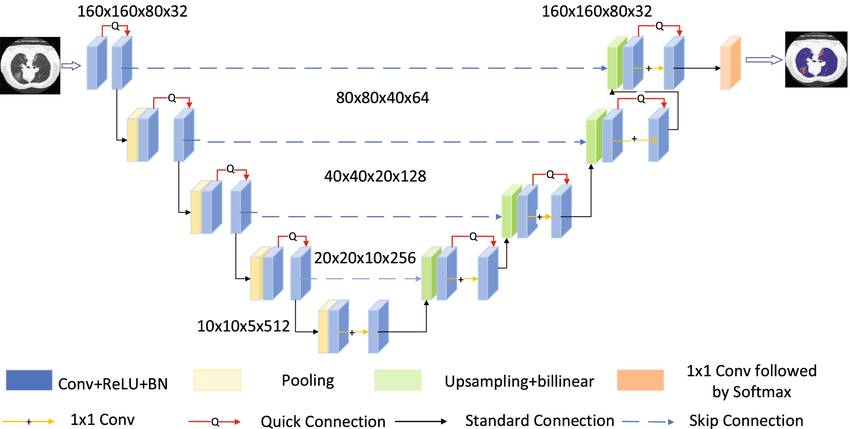

[link to the photo for reference](https://www.researchgate.net/figure/3D-U-Net-architecture-diagram_fig4_356508313)


**Skip Connections:**

torch.cat((upX, encX), dim=1) combines the feature maps from the encoder and the corresponding upsampled decoder layer.
These connections preserve high-resolution details, essential for precise segmentation.


**Hierarchical Features:**

Low-level (fine-grained) and high-level (abstract) features are learned by the encoder and combined in the decoder.


**Bottleneck:**

The deepest part of the network learns abstract global features that help in contextual segmentation.

In [ ]:
class UNet3D(nn.Module):
    def __init__(self):
        super(UNet3D, self).__init__()
        # Contracting Path
        self.enc1 = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),  # Batch Normalization
            nn.ReLU(),
            #nn.Dropout3d(0.3),  # Dropout
            nn.Conv3d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),  # Batch Normalization
            nn.ReLU(),
            #nn.Dropout3d(0.3)  # Dropout
        )
        self.pool1 = nn.MaxPool3d(2)

        self.enc2 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            #nn.Dropout3d(0.3),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            #nn.Dropout3d(0.3)
        )
        self.pool2 = nn.MaxPool3d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            #nn.Dropout3d(0.3),
            nn.Conv3d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            #nn.Dropout3d(0.3)
        )

        # Expanding Path
        self.upconv2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv3d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            #nn.Dropout3d(0.3),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            #nn.Dropout3d(0.3)
        )

        self.upconv1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv3d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            #nn.Dropout3d(0.3),
            nn.Conv3d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            #nn.Dropout3d(0.3)
        )

        # Output Layer
        self.final = nn.Conv3d(32, 1, kernel_size=1)

    def forward(self, x):
        # Contracting Path
        enc1 = self.enc1(x)  # First encoding layer
        pool1 = self.pool1(enc1)

        enc2 = self.enc2(pool1)  # Second encoding layer
        pool2 = self.pool2(enc2)

        # Bottleneck
        bottleneck = self.bottleneck(pool2)

        # Expanding Path
        up2 = self.upconv2(bottleneck)
        cat2 = torch.cat((up2, enc2), dim=1)  # Skip connection - concatenates feature maps from the encoder and the corresponding upsampled decoder layer
        dec2 = self.dec2(cat2)

        up1 = self.upconv1(dec2)
        cat1 = torch.cat((up1, enc1), dim=1)  # Skip connection
        dec1 = self.dec1(cat1)

        # Output
        out = self.final(dec1)
        return out


Contracting Path:

Encoder 1: 2 convolutional layers (Conv3d with 32 filters each) and 1 ReLU per layer.
MaxPool3d: Reduces spatial dimensions by half.

Encoder 2: 2 convolutional layers (Conv3d with 64 filters each) and 1 ReLU per layer.

MaxPool3d: Reduces spatial dimensions by half again.
Bottleneck:

2 convolutional layers (Conv3d with 128 filters each) and 1 ReLU per layer.
Expanding Path:

Decoder 2: 1 ConvTranspose3d layer (upsampling) followed by 2 convolutional layers (Conv3d with 64 filters each) and ReLU.

Decoder 1: 1 ConvTranspose3d layer (upsampling) followed by 2 convolutional layers (Conv3d with 32 filters each) and ReLU.

Final Layer:
1 Conv3d layer (1 filter) for voxel-wise segmentation.

## DataLoader and Training

In [ ]:
# Prepare the dataset
train_dataset = TensorDataset(
    torch.tensor(all_filtered_volumes).unsqueeze(1).float(),  # Shape: [batch_size, 1, D, H, W]
    torch.tensor(all_filtered_labels).unsqueeze(1).float()   # Shape: [batch_size, 1, D, H, W]
)

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Get the dataset size
dataset_size = len(train_dataset)

# Calculate sizes for train, validation, and test sets
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    train_dataset, [train_size, val_size, test_size]
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Initialize Model, Optimizer, and Dice Loss
model = UNet3D().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001) # lr=0.001
criterion = DiceLoss(sigmoid=True)  # Automatically applies sigmoid activation

In [ ]:
train_losses = []
val_losses = []

# Training Loop
for epoch in range(400):
    model.train()
    train_epoch_loss = 0

    # Training phase
    for inputs, labels in train_loader:
        # Send data to device (GPU/CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)

        # Compute Dice Loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()

    # Compute average training loss for the epoch
    avg_train_loss = train_epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_epoch_loss = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Send data to device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute Dice Loss
            loss = criterion(outputs, labels)
            val_epoch_loss += loss.item()

    # Compute average validation loss for the epoch
    avg_val_loss = val_epoch_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print training and validation loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch + 1}, "
            f"Train Loss: {avg_train_loss:.4f}, "
            f"Validation Loss: {avg_val_loss:.4f}"
        )

# Save the model
torch.save(model.state_dict(), "3d_unet_model_thyroglobulin.pth")

Epoch 10, Train Loss: 0.8020, Validation Loss: 0.8828
Epoch 20, Train Loss: 0.5736, Validation Loss: 0.7332
Epoch 30, Train Loss: 0.4634, Validation Loss: 0.6955
Epoch 40, Train Loss: 0.4042, Validation Loss: 0.7556
Epoch 50, Train Loss: 0.3619, Validation Loss: 0.7490
Epoch 60, Train Loss: 0.3280, Validation Loss: 0.7554
Epoch 70, Train Loss: 0.2906, Validation Loss: 0.7762
Epoch 80, Train Loss: 0.2629, Validation Loss: 0.8093
Epoch 90, Train Loss: 0.2630, Validation Loss: 0.7588
Epoch 100, Train Loss: 0.2341, Validation Loss: 0.7444
Epoch 110, Train Loss: 0.2137, Validation Loss: 0.7461
Epoch 120, Train Loss: 0.2113, Validation Loss: 0.7504
Epoch 130, Train Loss: 0.1906, Validation Loss: 0.7896
Epoch 140, Train Loss: 0.2070, Validation Loss: 0.7500
Epoch 150, Train Loss: 0.1802, Validation Loss: 0.7658
Epoch 160, Train Loss: 0.1686, Validation Loss: 0.7346
Epoch 170, Train Loss: 0.1780, Validation Loss: 0.7584
Epoch 180, Train Loss: 0.1698, Validation Loss: 0.7342
Epoch 190, Train Lo

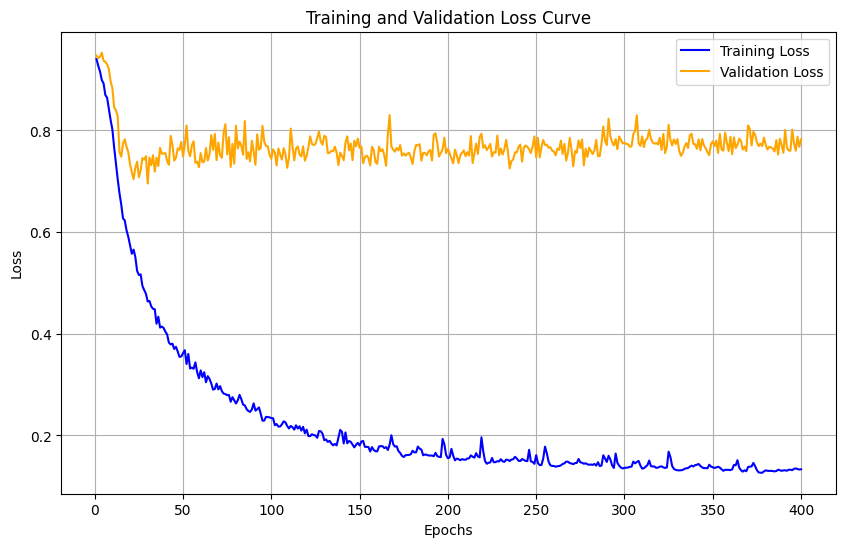

In [ ]:
# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", color="blue")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# 6) Evaluate Model Performance

## Prediction Visualization and Metrics

In [ ]:
# Load entire model
model.load_state_dict(torch.load("3d_unet_model_thyroglobulin.pth"))

<ipython-input-37-90e481d0bf3d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("3d_unet_model_ribosome.pth"))


<All keys matched successfully>

In [ ]:
# Initialize the count for zero slices
zero_slices_count = 0
non_zero_elements = []

# Iterate over all filtered labels
for filtered_label in all_filtered_labels:
    # Check if the slice is all zeros
    # Check if all values are numerically close to zero (e.g., within a tolerance)
    tolerance = 1e-6  # Adjust tolerance as needed
    if np.all(np.abs(filtered_label) < tolerance):
      zero_slices_count += 1

    else:
        # If not zero, append the non-zero slice
        non_zero_elements.append(filtered_label)

# Convert non-zero elements to a numpy array (optional, depending on what you need)
non_zero_elements = np.array(non_zero_elements)

# Calculate the percentage of zero slices
total_slices = len(all_filtered_labels)
percentage_zero_slices = (zero_slices_count / total_slices) * 100

# Print the results
print(f"Total slices: {total_slices}")
print(f"Zero slices count: {zero_slices_count}")
print(f"Percentage of zero slices: {percentage_zero_slices:.2f}%")
print(f"Non-zero elements count: {len(non_zero_elements)}")


Total slices: 580
Zero slices count: 0
Percentage of zero slices: 0.00%
Non-zero elements count: 580


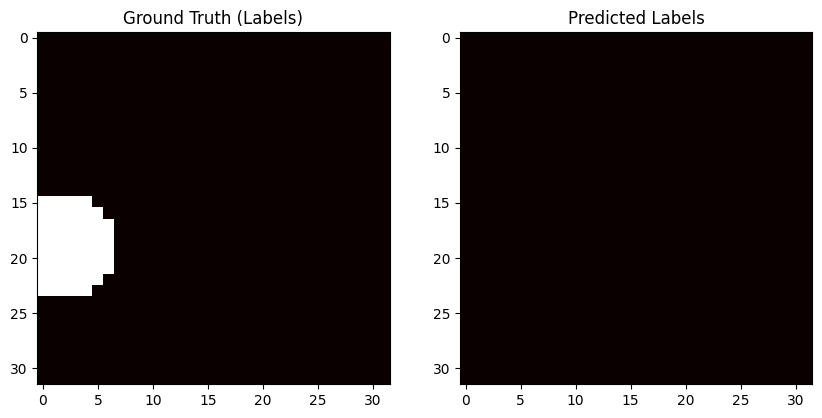

In [ ]:
# Example for calculating and visualizing predictions
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    sample_input = torch.tensor(all_filtered_volumes[30]).unsqueeze(0).unsqueeze(1).float().to(device)  # Get one sample
    predicted = model(sample_input).cpu().numpy()

# Take the middle slice along the z-axis
predicted_slice = np.take(predicted[0], all_filtered_labels[30].shape[0] // 2, axis=2) #80 # shape[2]
true_slice = np.take(all_filtered_labels[30], all_filtered_labels[30].shape[0] // 2, axis=2) # shape[2]

# Squeeze the extra dimension from the predictions
predicted_slice = np.squeeze(predicted_slice > 0.5)

# Visualize the prediction and true label
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(true_slice, cmap='hot')
axes[0].set_title('Ground Truth (Labels)')
axes[1].imshow(predicted_slice, cmap='hot')
axes[1].set_title('Predicted Labels')
plt.show()

For training set:

Accuracy: 0.9992
Precision: 0.9752
Recall: 0.9595
F1 Score: 0.9673


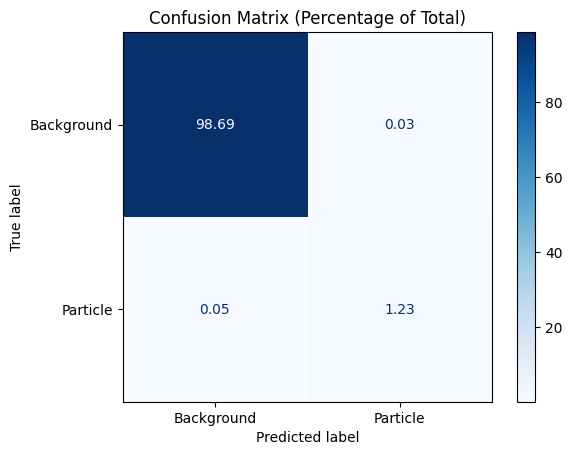

In [ ]:
# Initialize variables to accumulate metrics across all batches
all_true_labels = []
all_predicted_labels = []

# Loop through the training or evaluation loop
for inputs, labels in train_loader:  # Use the appropriate DataLoader (train_loader or test_loader)
    inputs, labels = inputs.float().to(device), labels.float().to(device)
    outputs = model(inputs)
    outputs = F.interpolate(outputs, size=labels.shape[2:], mode='trilinear', align_corners=True)

    # Flatten the labels and predictions for this batch
    all_true_labels.append(labels.flatten().cpu().numpy())
    all_predicted_labels.append((outputs.flatten() > 0.5).cpu().numpy())  # Binary classification (threshold at 0.5)

# Concatenate the lists into arrays
all_true_labels = np.concatenate(all_true_labels)
all_predicted_labels = np.concatenate(all_predicted_labels)

# Compute the metrics for the entire dataset
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
precision = precision_score(all_true_labels, all_predicted_labels)
recall = recall_score(all_true_labels, all_predicted_labels)
f1 = f1_score(all_true_labels, all_predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Normalize the confusion matrix to show percentages (by total content)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum() * 100

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Background", "Particle"])

disp.plot(cmap="Blues", values_format=".2f")
plt.title("Confusion Matrix (Percentage of Total)")
plt.show()

For the test set:


Accuracy: 0.9907
Precision: 0.5010
Recall: 0.3374
F1 Score: 0.4032


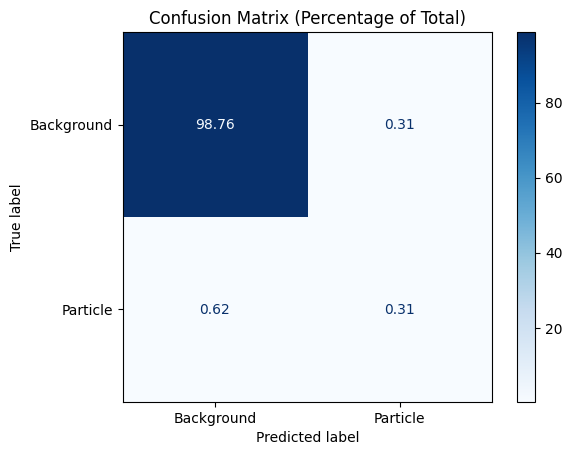

In [ ]:
# Initialize variables to accumulate metrics across all batches
all_true_labels = []
all_predicted_labels = []

# Loop through the training or evaluation loop
for inputs, labels in test_loader:  # Use the appropriate DataLoader (train_loader or test_loader)
    inputs, labels = inputs.float().to(device), labels.float().to(device)
    outputs = model(inputs)
    outputs = F.interpolate(outputs, size=labels.shape[2:], mode='trilinear', align_corners=True)

    # Flatten the labels and predictions for this batch
    all_true_labels.append(labels.flatten().cpu().numpy())
    all_predicted_labels.append((outputs.flatten() > 0.5).cpu().numpy())  # Binary classification (threshold at 0.5)

# Concatenate the lists into arrays
all_true_labels = np.concatenate(all_true_labels)
all_predicted_labels = np.concatenate(all_predicted_labels)

# Compute the metrics for the entire dataset
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
precision = precision_score(all_true_labels, all_predicted_labels)
recall = recall_score(all_true_labels, all_predicted_labels)
f1 = f1_score(all_true_labels, all_predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Normalize the confusion matrix to show percentages (by total content)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum() * 100

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Background", "Particle"])

disp.plot(cmap="Blues", values_format=".2f")
plt.title("Confusion Matrix (Percentage of Total)")
plt.show()

Next Steps:

* Continue improving preprocessing by experimenting with different subvolume sizes and background fraction.

* Visualize model performance with more slices and 3D blobs.

* Experiment with different models (e.g., adding more layers or using different loss functions like Dice Loss for imbalanced data).